<div style="background: #efffed;
            border: 1px solid grey;
            margin: 8px 0 8px 0;
            text-align: center;
            padding: 8px; ">
    <i class="fa-play fa" 
       style="font-size: 40px;
              line-height: 40px;
              margin: 8px;
              color: #444;">
    </i>
    <div>
    To run the selected code cell, hit <pre style="background: #efffed">Shift + Enter</pre>
    </div>
</div>

In [1]:
import numpy as np

In [2]:
import sys
sys.path.append("../")
from src.Structure import AtomCls
from src.Atomic import LTELib, ColExcite, SEsolver
from src.RadiativeTransfer import Thin

restore atomic model

In [3]:
file     = "../atom/C_III/C_III.Level"
file_Aji = "../atom/C_III/Einstein_A/Nist.Aji"
file_CEe = "../atom/C_III/Collisional_Excitation/Berrington_et_al_1985.Electron"
atom = AtomCls.Atom(file, _file_Aji=file_Aji, _file_CEe=file_CEe)

Reading Einstein Aji coefficient from : 
 ../atom/C_III/Einstein_A/Nist.Aji
...
Finished.

Reading Electron impact Effective Collisional Strength from : 
 ../atom/C_III/Collisional_Excitation/Berrington_et_al_1985.Electron
...
Finished.



environment

In [4]:
Te = 2E+04
ne = 1E+10

compute the LTE population ratio first

In [5]:
#--- compute LTE population ratio for each CE transition
n_LTE = LTELib.get_LTE_ratio(_erg=atom.Level.erg[:], _g=atom.Level.g[:],
                _stage=atom.Level.stage[:], _Te=Te, _Ne=ne)

we are going to use LTE population ratio to convert `C_{ij}` to `C_{ji}` 

In [6]:
nTran = atom.CE_table.shape[0]
ni_LTE = np.empty(nTran, np.double)
nj_LTE = np.empty(nTran, np.double)

for k in range(nTran):
    ni_LTE[k] = n_LTE[atom.CE_coe.idxI[k]]
    nj_LTE[k] = n_LTE[atom.CE_coe.idxJ[k]]

In [7]:
#--- compute collision excitation/de-excitation rate coefficient
CE_fac = ColExcite.interpolate_CE_fac(_table=atom.CE_table[:,:], _Te=Te, _Te_table=atom.CE_Te_table[:],
                            _f1=atom.CE_coe.f1[:], _f2=atom.CE_coe.f2[:])
CEij = ColExcite.get_CE_rate_coe(_CE_fac=CE_fac, _Te=Te, _gi=atom.CE_coe.gi[:],
                            _dEij=atom.CE_coe.dEij[:], _type=atom.CE_type)

CEji = ColExcite.Cij_to_Cji(_Cij=CEij,  _ni_LTE=ni_LTE, _nj_LTE=nj_LTE)

solve SE equations under the assumption of "Corona equilibrium"

In [8]:
#--- solve SE equations
nLevel = atom.nLevel
Cmat = np.zeros((nLevel, nLevel), np.double)
Rmat = np.zeros((nLevel, nLevel), np.double)
SEsolver.setMatrixC(_Cmat=Cmat[:,:], _Cji=CEji[:], _Cij=CEij[:],
            _idxI=atom.CE_coe.idxI[:], _idxJ=atom.CE_coe.idxJ[:], _Ne=ne)

Rji_stim = np.zeros(atom.Line.AJI[:].shape, np.double)
Rij = np.zeros(atom.Line.AJI[:].shape, np.double)
SEsolver.setMatrixR(_Rmat=Rmat[:,:], _Rji_spon=atom.Line.AJI[:],
    _Rji_stim=Rji_stim[:], _Rij=Rij, _idxI=atom.Line.idxI[:], _idxJ=atom.Line.idxJ[:])

n_SE = SEsolver.solveSE(_Rmat=Rmat[:,:], _Cmat=Cmat[:,:])

In [9]:
n_SE

array([8.96779005e-01, 1.13324877e-02, 3.25819128e-02, 5.93065916e-02,
       1.97528156e-09, 2.32191744e-11, 7.27294410e-11, 1.23057397e-10,
       2.90502654e-10, 1.35028077e-13])

compute relative flux for each transition

In [10]:
#-- compute optically thin relative flux
nj_SE = np.empty(nTran, np.double)
for k in range(nTran):
    nj_SE[k] = n_SE[atom.CE_coe.idxJ[k]]

rel_flux = Thin.get_relative_flux(_AJI=atom.Line.AJI[:], _f0=atom.Line.f0[:], _nj=nj_SE[:])

---

In [11]:
import matplotlib.pyplot as plt

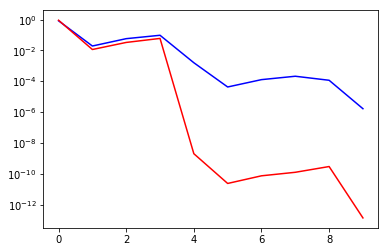

In [12]:
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(10), n_LTE, "-b", label="LTE")
ax.plot(np.arange(10), n_SE, "-r", label="SE")
ax.set_yscale("log")

---